In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi, threshold_otsu
from skimage.feature import canny, local_binary_pattern
from skimage import morphology
from glob import glob
from tqdm import tqdm

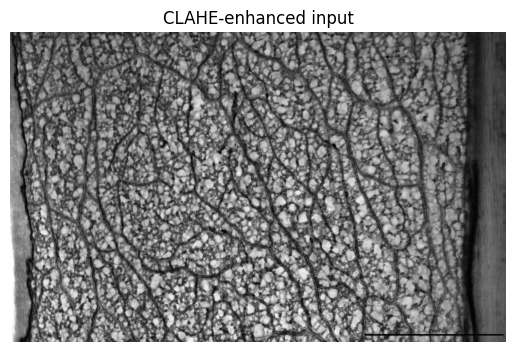

In [3]:
img_dir = "/home/smadper/TFM/datasets/laticifers/enhanced_images"
image_paths = sorted(glob(os.path.join(img_dir, "*.tif")))

# Load one image
img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE) / 255.0

plt.imshow(img, cmap='gray')
plt.title("CLAHE-enhanced input")
plt.axis('off')
plt.show()


In [4]:
# 1. Otsu Threshold
otsu_thresh = threshold_otsu(img)
otsu_mask = img > otsu_thresh

# 2. Canny Edges
canny_edges = cv2.Canny((img * 255).astype(np.uint8), 50, 150)

# 3. Frangi Filter (vesselness)
frangi_img = frangi(img)

# 4. Local Binary Pattern
lbp = local_binary_pattern(img, P=8, R=1.0, method='uniform')

# 5. Morphological Gradient
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
morph_grad = cv2.morphologyEx((img * 255).astype(np.uint8), cv2.MORPH_GRADIENT, kernel)

/home/smadper/pyenvs/tfm/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


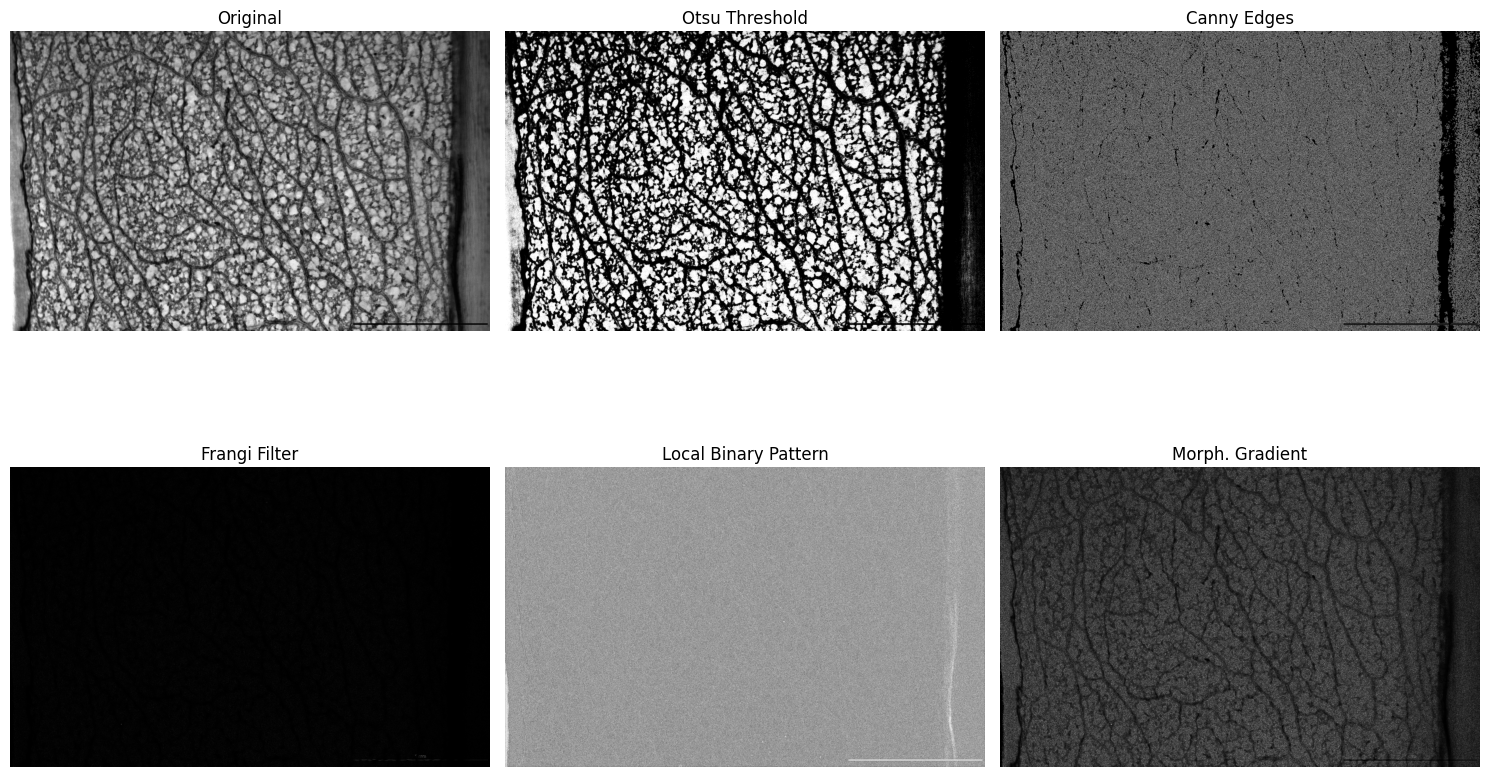

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(img, cmap='gray'); axs[0, 0].set_title("Original")
axs[0, 1].imshow(otsu_mask, cmap='gray'); axs[0, 1].set_title("Otsu Threshold")
axs[0, 2].imshow(canny_edges, cmap='gray'); axs[0, 2].set_title("Canny Edges")

axs[1, 0].imshow(frangi_img, cmap='gray'); axs[1, 0].set_title("Frangi Filter")
axs[1, 1].imshow(lbp, cmap='gray'); axs[1, 1].set_title("Local Binary Pattern")
axs[1, 2].imshow(morph_grad, cmap='gray'); axs[1, 2].set_title("Morph. Gradient")

for ax in axs.ravel(): ax.axis('off')
plt.tight_layout()
plt.show()


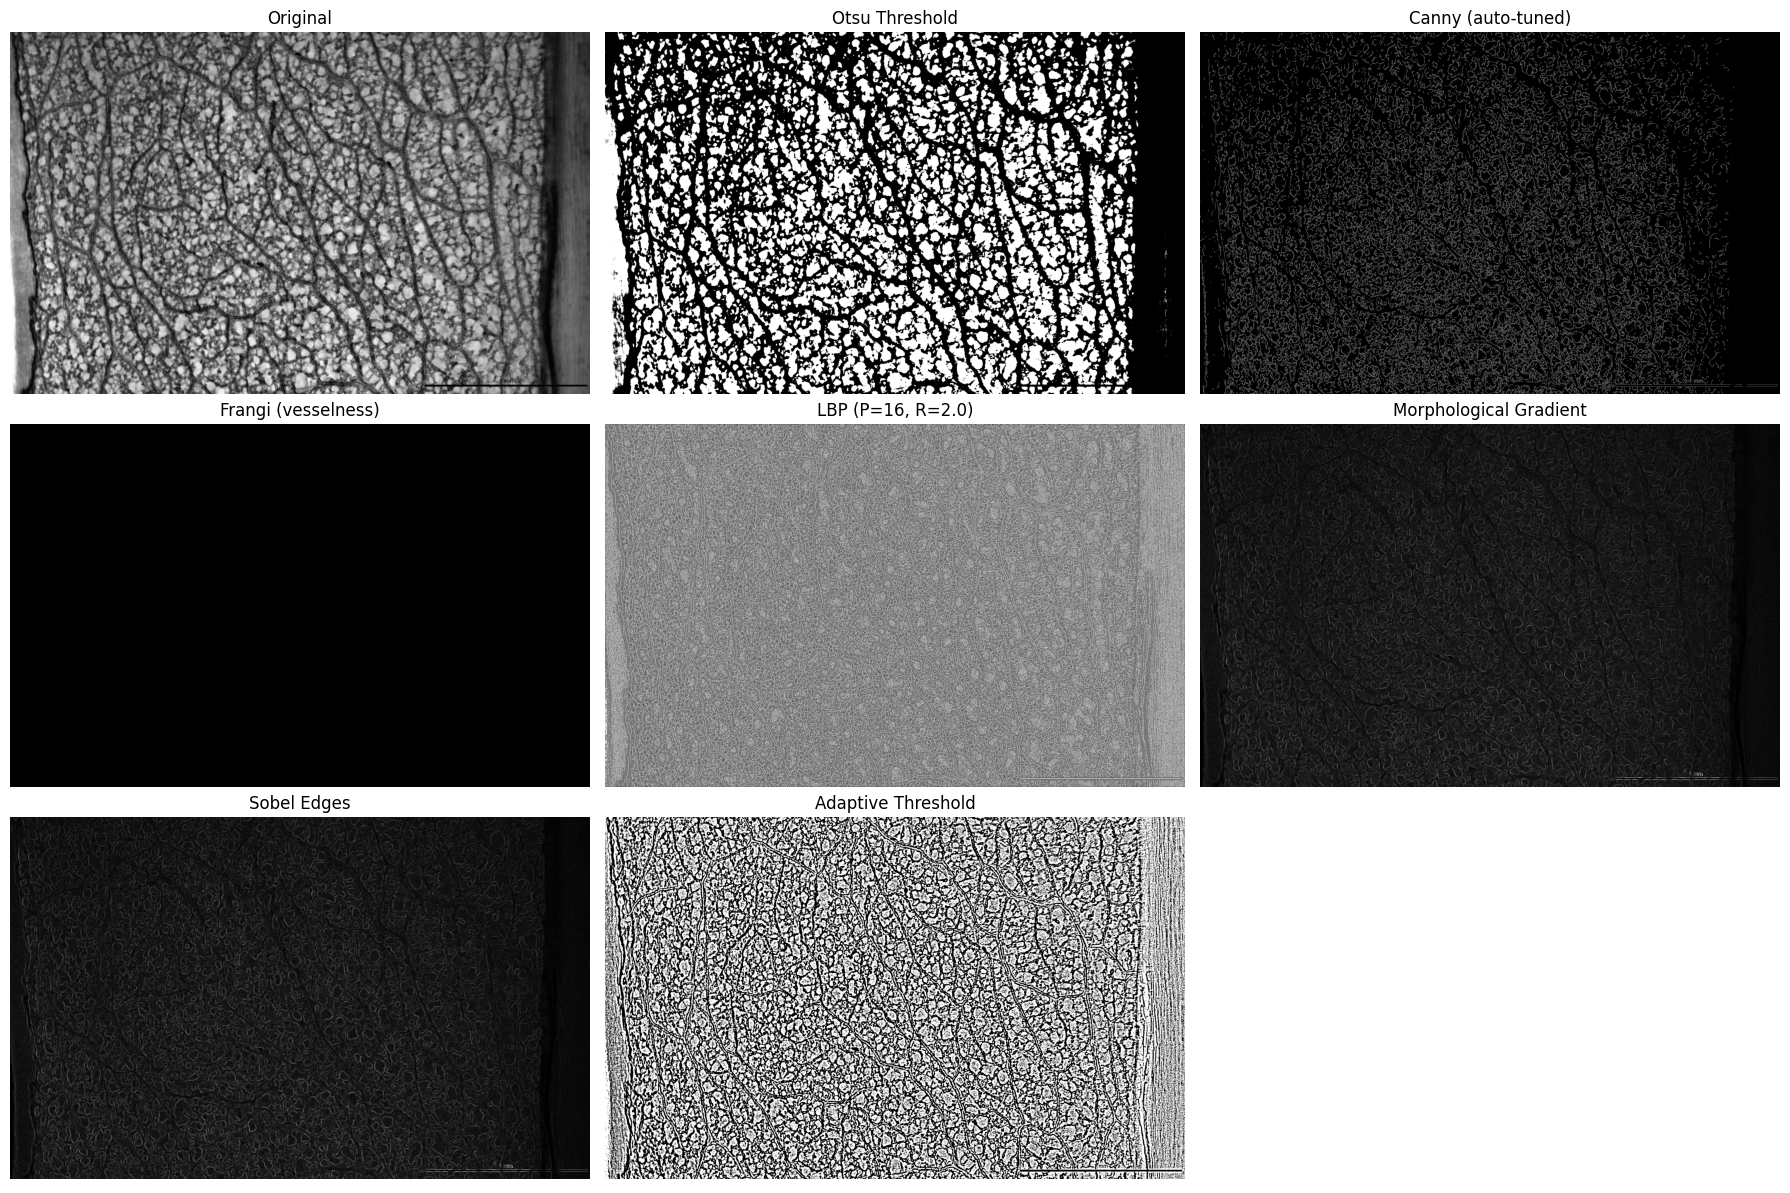

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi, threshold_otsu, sobel
from skimage.feature import local_binary_pattern
from skimage import morphology
from scipy.ndimage import gaussian_filter
from glob import glob

# Load image
img_dir = "/home/smadper/TFM/datasets/laticifers/enhanced_images"
image_paths = sorted(glob(os.path.join(img_dir, "*.tif")))

img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Optional: Apply Gaussian blur to reduce noise
blurred_img = gaussian_filter(img, sigma=1.0)

# 1. Otsu Threshold
otsu_thresh = threshold_otsu(blurred_img)
otsu_mask = blurred_img > otsu_thresh

# 2. Canny Edges (tuned thresholds)
v = np.median(blurred_img)
lower = int(max(0, (1.0 - 0.33) * v * 255))
upper = int(min(255, (1.0 + 0.33) * v * 255))
canny_edges = cv2.Canny((blurred_img * 255).astype(np.uint8), lower, upper)

# 3. Frangi Filter (tuned)
sigmas = np.arange(10, 20, 1)  # replaces scale_range=(1,4), scale_step=1
frangi_img = frangi(blurred_img, sigmas=sigmas, alpha=0.5, beta=0.5, gamma=15, black_ridges=False)


# 4. Local Binary Pattern (tuned radius and points)
lbp = local_binary_pattern(blurred_img, P=16, R=2.0, method='uniform')

# 5. Morphological Gradient
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
morph_grad = cv2.morphologyEx((blurred_img * 255).astype(np.uint8), cv2.MORPH_GRADIENT, kernel)

# 6. Sobel Edges
sobel_edges = sobel(blurred_img)

# 7. Adaptive Thresholding (works well on CLAHE images)
adaptive_thresh = cv2.adaptiveThreshold((blurred_img * 255).astype(np.uint8),
                                        maxValue=255,
                                        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        thresholdType=cv2.THRESH_BINARY,
                                        blockSize=31,
                                        C=2)

# --- Plot ---
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

axs[0, 0].imshow(img, cmap='gray'); axs[0, 0].set_title("Original")
axs[0, 1].imshow(otsu_mask, cmap='gray'); axs[0, 1].set_title("Otsu Threshold")
axs[0, 2].imshow(canny_edges, cmap='gray'); axs[0, 2].set_title("Canny (auto-tuned)")

axs[1, 0].imshow(frangi_img, cmap='gray'); axs[1, 0].set_title("Frangi (vesselness)")
axs[1, 1].imshow(lbp, cmap='gray'); axs[1, 1].set_title("LBP (P=16, R=2.0)")
axs[1, 2].imshow(morph_grad, cmap='gray'); axs[1, 2].set_title("Morphological Gradient")

axs[2, 0].imshow(sobel_edges, cmap='gray'); axs[2, 0].set_title("Sobel Edges")
axs[2, 1].imshow(adaptive_thresh, cmap='gray'); axs[2, 1].set_title("Adaptive Threshold")
axs[2, 2].axis('off')  # Empty

for ax in axs.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()
